#### Libraries import

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [4]:
from catboost import CatBoostClassifier, Pool

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
import random

#### Fix random seed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)

seed = 123
seed_everything(seed)

#### Data import

In [8]:
df_train_init = pd.read_csv(r"train.csv", na_values=np.nan)

In [9]:
df_submission_init = pd.read_csv(r"test.csv", na_values=np.nan)

#### Data preprocessing

In [10]:
X_train, y_train = df_train_init.drop(['Transported'], axis=1), df_train_init['Transported']

In [11]:
y_train = y_train.apply(float)

In [12]:
X_submission = df_submission_init.copy()

In [13]:
submission_id = X_submission['PassengerId'].tolist()

In [14]:
df_train_init.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [15]:
df_train_init['Transported'].value_counts(normalize=True)

True     0.503624
False    0.496376
Name: Transported, dtype: float64

In [16]:
df_train_init.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [17]:
df_train_init.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [18]:
df_train_init.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

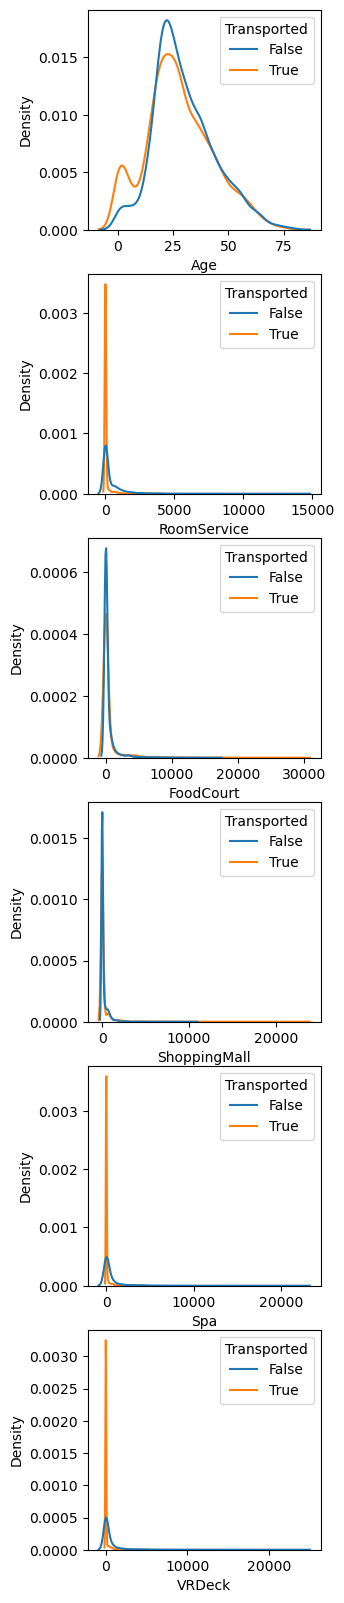

In [19]:
fig, ax = plt.subplots(6, 1, figsize=(3, 20))

for i, col in enumerate(df_train_init.columns[(df_train_init.dtypes != 'object')].tolist()):
    if col != 'Transported':
        sns.kdeplot(data=df_train_init, x=col, hue='Transported', ax=ax[i], warn_singular=False)

In [20]:
df_train_init.groupby(['HomePlanet'])['Transported'].mean()

HomePlanet
Earth     0.423946
Europa    0.658846
Mars      0.523024
Name: Transported, dtype: float64

In [21]:
df_train_init.groupby(['CryoSleep'])['Transported'].mean()

CryoSleep
False    0.328921
True     0.817583
Name: Transported, dtype: float64

In [22]:
df_train_init.groupby(['Destination'])['Transported'].mean()

Destination
55 Cancri e      0.610000
PSO J318.5-22    0.503769
TRAPPIST-1e      0.471175
Name: Transported, dtype: float64

In [23]:
df_train_init.groupby(['Destination'])['VIP'].mean()

Destination
55 Cancri e      0.036995
PSO J318.5-22    0.023256
TRAPPIST-1e      0.019720
Name: VIP, dtype: float64

"PassengerId" feature is divided into 2 new features: "PassengerId_group" and "PassengerId_number"

In [24]:
X_train = pd.concat([X_train, pd.DataFrame(data=X_train['PassengerId'].apply(lambda x: list(map(int, x.split('_')))).tolist(), columns=['PassengerId_group', 'PassengerId_number'])], axis=1).drop(['PassengerId'], axis=1)

"Cabin" feature is divided into 3 new features: "Cabin_deck", "Cabin_num", "Cabin_side"

In [25]:
X_train = pd.concat([X_train, pd.DataFrame(data=X_train['Cabin'].apply(lambda x: str(x).split('/')).tolist(), columns=['Cabin_deck', 'Cabin_num', 'Cabin_side'])], axis=1).drop(['Cabin'], axis=1)

"Name" is divided into 2 new features: "First Name" and "Surname"

In [26]:
X_train = pd.concat([X_train, pd.DataFrame(data=X_train['Name'].apply(lambda x: [np.nan, np.nan] if pd.isna(x) else x.split()).tolist(), columns=['First Name', 'Surname'])], axis=1).drop(['Name'], axis=1)

In [27]:
X_train['Cabin_num'] = X_train['Cabin_num'].astype(float)

In [28]:
X_train['CryoSleep'] = X_train['CryoSleep'].astype(float)

In [29]:
X_train['VIP'] = X_train['VIP'].astype(float)

new feature "ServiceFeesSum" is created

In [30]:
X_train['ServiceFeesSum'] = X_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

new feature "Nulls" is created

In [31]:
X_train['Nulls'] = X_train.isnull().sum(axis=1)

new 1000 tf-idf features out of "Surname" feature are created

In [32]:
fullname_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 1), min_df=1)

In [33]:
X_train_fullname_tf_idf = pd.DataFrame(data=fullname_vectorizer.fit_transform(X_train['Surname'].fillna('')).toarray(), columns=fullname_vectorizer.get_feature_names_out())

1000 tf-idf features are replaced by 10 most informative principal components

In [34]:
pca = PCA(10)

In [35]:
X_train_fullname_tf_idf_pca = pd.DataFrame(pca.fit_transform(X_train_fullname_tf_idf))

In [36]:
X_train = pd.concat([X_train, X_train_fullname_tf_idf_pca], axis=1)

the same is done for submission dataset

In [37]:
X_submission = pd.concat([X_submission, pd.DataFrame(data=X_submission['PassengerId'].apply(lambda x: list(map(int, x.split('_')))).tolist(), columns=['PassengerId_group', 'PassengerId_number'])], axis=1).drop(['PassengerId'], axis=1)

In [38]:
X_submission = pd.concat([X_submission, pd.DataFrame(data=X_submission['Cabin'].apply(lambda x: str(x).split('/')).tolist(), columns=['Cabin_deck', 'Cabin_num', 'Cabin_side'])], axis=1).drop(['Cabin'], axis=1)

In [39]:
X_submission = pd.concat([X_submission, pd.DataFrame(data=X_submission['Name'].apply(lambda x: [np.nan, np.nan] if pd.isna(x) else x.split()).tolist(), columns=['First Name', 'Surname'])], axis=1).drop(['Name'], axis=1)

In [40]:
X_submission['Cabin_num'] = X_submission['Cabin_num'].astype(float)

In [41]:
X_submission['CryoSleep'] = X_submission['CryoSleep'].astype(float)

In [42]:
X_submission['VIP'] = X_submission['VIP'].astype(float)

In [43]:
X_submission['ServiceFeesSum'] = X_submission[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [44]:
X_submission['Nulls'] = X_submission.isnull().sum(axis=1)

In [45]:
X_submission_tf_idf = pd.DataFrame(data=fullname_vectorizer.transform(X_submission['Surname'].fillna('')).toarray(), columns=fullname_vectorizer.get_feature_names_out())

In [46]:
X_submission_tf_idf_pca = pd.DataFrame(pca.fit_transform(X_submission_tf_idf))

In [47]:
X_submission = pd.concat([X_submission, X_submission_tf_idf_pca], axis=1)

nulls are replaced

In [48]:
categorical_features = X_submission.columns[X_submission.dtypes == 'object'].tolist()
numeric_features = X_submission.columns[X_submission.dtypes != 'object'].tolist()

In [49]:
for col in categorical_features:
    X_submission[col] = X_submission[col].fillna('None')
    X_train[col] = X_train[col].fillna('None')

In [50]:
for col in numeric_features:
    val = X_train[col].median()
    X_submission[col] = X_submission[col].fillna(val)
    X_train[col] = X_train[col].fillna(val)

In [51]:
for col in categorical_features:
    X_submission[col] = pd.Categorical(X_submission[col])
    X_train[col] = pd.Categorical(X_train[col])

#### Model fitting

In [52]:
catboost_model = CatBoostClassifier(iterations=1000, verbose=0, random_seed=seed, eval_metric='Accuracy')

In [53]:
pool = Pool(data=X_train,
            label=y_train,
            cat_features=categorical_features)

In [54]:
catboost_model.fit(pool)

#### Features importance estimation

In [55]:
feature_importances = pd.DataFrame()
feature_importances['Feature'] = X_train.columns.tolist()
feature_importances['Importance'] = catboost_model.feature_importances_.tolist()

In [56]:
feature_importances.sort_values(by='Importance', ascending=False)

,Feature,Importance
17,ServiceFeesSum,11.936829
8,Spa,9.592415
9,VRDeck,8.292712
12,Cabin_deck,7.775866
0,HomePlanet,7.523307
6,FoodCourt,7.192985
13,Cabin_num,6.224594
5,RoomService,4.827435
14,Cabin_side,4.584357
1,CryoSleep,4.365846


#### Prediction threshold setting

In [57]:
thr = 0.51

#### Train data accuracy evaluation

In [58]:
accuracy_score((catboost_model.predict_proba(X_train)[:, 1] > thr), y_train)

0.875647072357069

#### Submission dataset prediction

In [59]:
result_df = pd.DataFrame()
result_df['PassengerId'] = submission_id
result_df['Transported'] = (catboost_model.predict_proba(X_submission)[:, 1] > thr)

In [60]:
result_df.to_csv(r"submission.csv", index=False)

submission dataset accuracy - 0.81014 <br>
result - top 3% leaderboard